<a href="https://colab.research.google.com/github/Fredrick-Ofodongoro/CompilerConstructionLabs/blob/main/LabActivity2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CC Lab 2 (NFA to DFA, Bison and Flex)

#Question 1
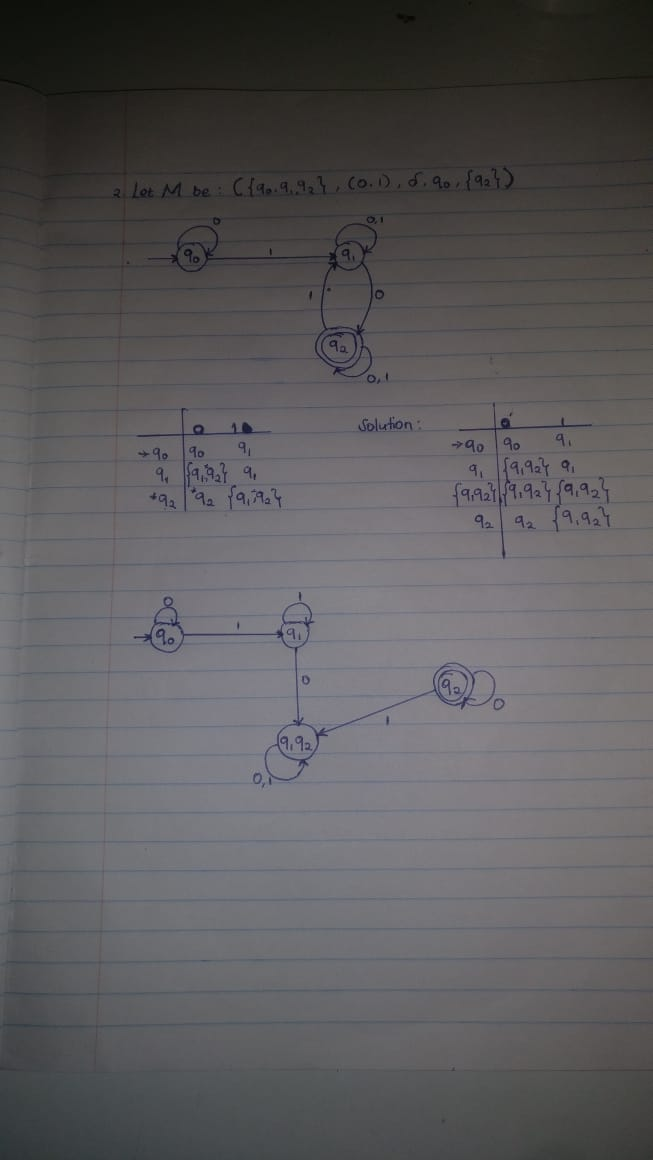 

1. 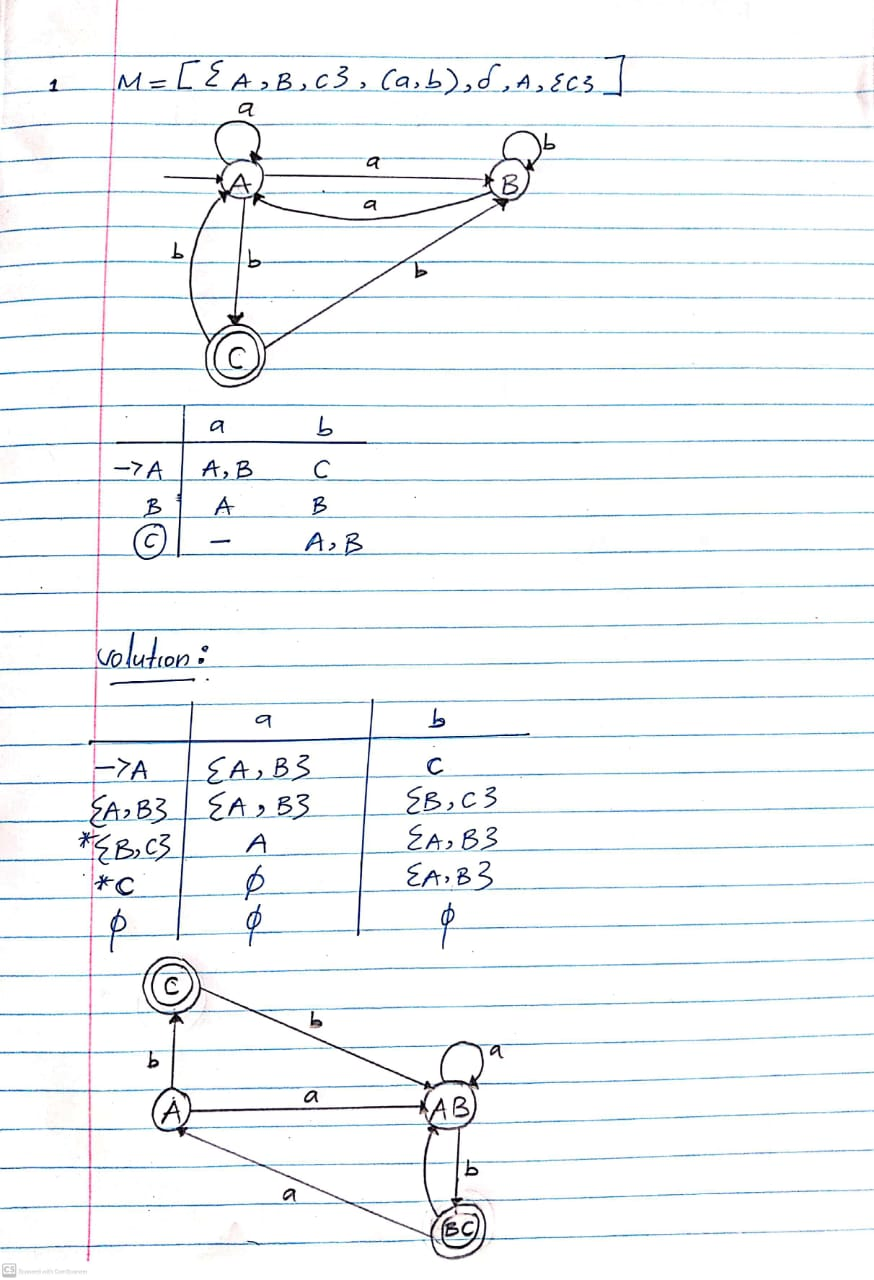

#Question 2

 A flex program consists of three sections, separated by %% lines. The first section contains declarations and option settings. The second section is a list of patterns and actions, and the third section is C code that is copied to the generated scanner, usually small routines related to the code in the actions.

Some applications are simple enough that you can write the whole thing in flex, or in flex with a little bit of C. For example,

In [ ]:
/* English -> American */
%%
"colour" { printf("color"); }
"flavour" { printf("flavor"); }
"clever" { printf("smart"); }
"smart" { printf("elegant"); }
"conservative" { printf("liberal"); }
 … lots of other words …
. { printf("%s", yytext); }
%%

**Putting Flex and Bison Together**

Flx and Bison can be used together when parsing. The first program we’ll write using both flex and bison is a desk calculator. First we’ll write a scanner, and then we’ll write a parser and splice the two of them together.

To keep things simple, we’ll start by recognizing only integers, four basic arithmetic operators, and a unary absolute value operator 

In [ ]:
/* recognize tokens for the calculator and print them out */
%%
"+"    { printf("PLUS\n"); }
"-"    { printf("MINUS\n"); }
"*"    { printf("TIMES\n"); }
"/"    { printf("DIVIDE\n"); }
"|"    { printf("ABS\n"); }
[0-9]+ { printf("NUMBER %s\n", yytext); }
\n     { printf("NEWLINE\n"); }
[ \t]  { }
.      { printf("Mystery character %s\n", yytext); }
%%

The first five patterns are literal operators, written as quoted strings, and the actions, for now, just print a message saying what matched. The quotes tell flex to use the strings as is, rather than interpreting them as regular expressions.

The sixth pattern matches an integer. The bracketed pattern [0-9]matches any single digit, and the following + sign means to match one or more of the preceding item, which here means a string of one or more digits. The action prints out the string that’s matched, using the pointer yytext that the scanner sets after each match.

The seventh pattern matches a newline character, represented by the usual C \n sequence.

The eighth pattern ignores whitespace. It matches any single space or tab (\t), and the empty action code does nothing.

The final pattern is the catchall to match anything the other patterns didn’t. Its action code prints a suitable complaint.

These nine patterns now provide rules to match anything that the user might enter. As we continue to develop the calculator, we’ll add more rules to match more tokens, but these will do to get us started.

In this simple flex program, there’s no C code in the third section. The flex library (-lfl) provides a tiny main program that just calls the scanner, which is adequate for this example.

**Grammars and Parsing**

The parser’s job is to figure out the relationship among the input tokens. A common way to display such relationships is a parse tree. For example, under the usual rules of arithmetic, the arithmetic expression 1 * 2 + 3 * 4 + 5 would have the parse tree below

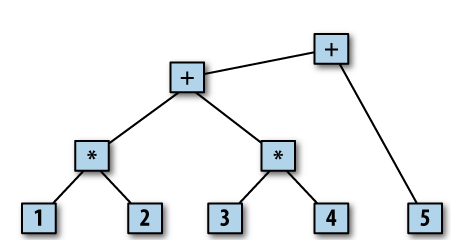

**BNF Grammars**

In order to write a parser, we need some way to describe the rules the parser uses to turn a sequence of tokens into a parse tree. The most common kind of language that computer parsers handle is a context-free grammar (CFG). The standard form to write down a CFG is Backus-Naur Form (BNF), created around 1960 to describe Algol 60 and named after two members of the Algol 60 committee.
Fortunately, BNF is quite simple. Here’s BNF for simple arithmetic expressions enough to handle 1 * 2 + 3 * 4 + 5:

In [ ]:
<exp> ::= <factor> 
      | <exp> + <factor>
<factor> ::= NUMBER
      | <factor> * NUMBER

Each line is a rule that says how to create a branch of the parse tree. In BNF, ::= can be read “is a” or “becomes,” and | is “or,” another way to create a branch of the same kind. The name on the left side of a rule is a symbol or term. By convention, all tokens are considered to be symbols, but there are also symbols that are not tokens.

Useful BNF is invariably quite recursive, with rules that refer to themselves directly or indirectly. These simple rules can match an arbitrarily complex sequence of additions and multiplications by applying them recursively

**Bison's Rule Input Language**

Bison rules are basically BNF, with the punctuation simplified a little to make them easier to type. For example, the snippet below shows a version of a calculator whihc was created for the above flex code used.

In [ ]:
/* simplest version of calculator */
%{
#include <stdio.h>
%}

/* declare tokens */
%token NUMBER
%token ADD SUB MUL DIV ABS
%token EOL

%%

calclist: /* nothing */                       matches at beginning of input
 | calclist exp EOL { printf("= %d\n", $2); } EOL is end of an expression
 ;

exp: factor       default $$ = $1 
 | exp ADD factor { $$ = $1 + $3; }
 | exp SUB factor { $$ = $1 - $3; }
 ;

factor: term       default $$ = $1 
 | factor MUL term { $$ = $1 * $3; }
 | factor DIV term { $$ = $1 / $3; }
 ;

term: NUMBER  default $$ = $1 
 | ABS term   { $$ = $2 >= 0? $2 : - $2; }
;
%%
main(int argc, char **argv)
{
  yyparse();
}

yyerror(char *s)
{
  fprintf(stderr, "error: %s\n", s);
}




1st section
The declarations, which include C code to be copied to the beginning of the generated parser.
The tokens declarations, whihc tells Bison the names of the symbols in the parser that are tokens. Bison does not require that all tokens start with uppercases. 

2nd section 
Contains rules in simple BNF, C code goes in braces at the end of each rule. *Parsing is done Automatically by Bisonn helping the programmer remember the rules that have been matched*.
In this parser, the first two rules, which define the symbol **calclist**, implement a loop that reads an expression terminated by a newline and prints its value. The definition of calclist uses a common two-rule recursive idiom to implement a sequence or list: the first rule is empty and matches nothing; the second adds an item to the list. The action in the second rule prints the value of the exp in $2.

The other rules implement the calculator.